In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize, integrate, signal
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/var/folders/_2/b28clpbs6t36hp6grpxntpq40000gn/T/ipykernel_43068/2724250610.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_combined, df_concat]).reset_index(drop=True)


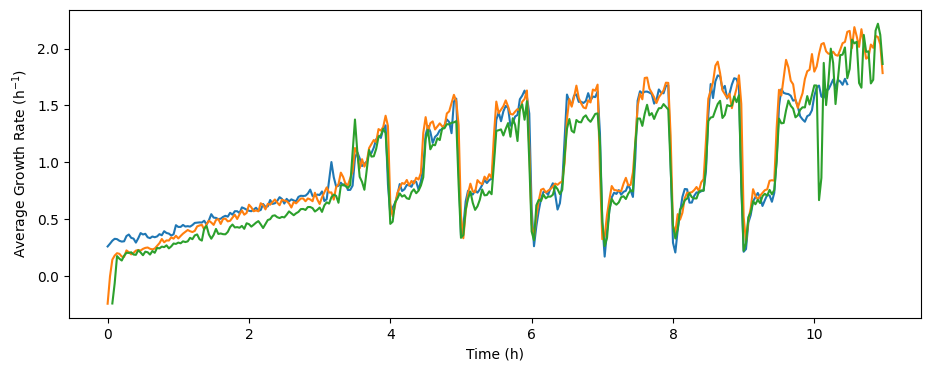

In [3]:
# bin average and combine all dataframes
df_index = [37,38,39]

n_bins = 330 # number of bins for averaging
t_min = 0
t_max = 11

plt.figure(figsize=(11,4))
df_combined = pd.DataFrame(columns=['t','GRate'])
for x in df_index:

    # import and clean data
    df_rate = pd.read_csv('Nguyen_Data/GRates_rep' + str(x) + '.csv')
    df_rate = df_rate.drop(df_rate.columns[[0]], axis=1) # dropping first column, not needed
    if x == 37:
        df_rate['t'] = df_rate['t'] - 0.5 # aligning time to match other replicates
    if x == 39:
        df_rate['t'] = df_rate['t'] + 0.08

    # bin average
    Time = np.linspace(t_min,t_max,n_bins+1)
    GRate_bin = np.zeros(len(Time))
    GRate_std = np.zeros(len(Time))
    n_points = len(Time)
    for i in range(n_points-1):
        GRate_x = df_rate.loc[(df_rate['t'] > Time[i]) & (df_rate['t'] < Time[i+1]), ['GRate']]
        GRate_bin[i] = np.mean(GRate_x)
    # removing last timepoint becuase its not binned properly
    Time = Time[0:-1] 
    GRate_bin = GRate_bin[0:-1]
    plt.plot(Time, GRate_bin) # plot each replicate

    # append data from each replicate
    Time = pd.DataFrame(Time, columns=['t'])
    GRate_bin = pd.DataFrame(GRate_bin, columns=['GRate'])
    df_concat = pd.concat([Time,GRate_bin], axis=1, join='inner')
    df_combined = pd.concat([df_combined, df_concat]).reset_index(drop=True)
    # df_combined = df_combined.append(df_concat).reset_index(drop=True) # depreciated

plt.xlabel('Time (h)')
plt.ylabel('Average Growth Rate (h$^{-1}$)')
plt.show()

In [ ]:
# Averaging growth rates from same timepoint

# averaging growth rates from same timepoint
Time = pd.unique(df_combined['t'])
GRates = np.zeros(len(Time))
std = np.zeros(len(Time))

i=0
for x in Time:

    kappas_i = df_combined.loc[(df_combined['t'] == x), ['GRate']] # returning all growth rates for specified timepoint
    GRates[i] = np.mean(kappas_i) # calculating mean growth rate for specified timepoint
    std[i] = np.std(kappas_i)

    i+=1

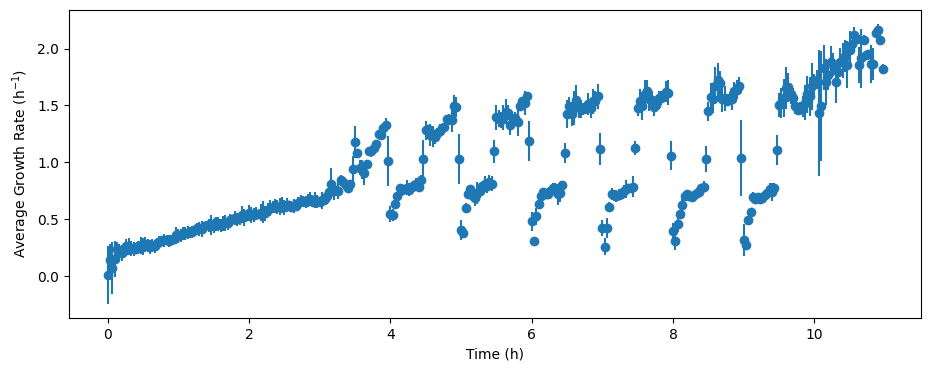

In [5]:
plt.figure(figsize=(11,4))
plt.errorbar(Time, GRates, yerr=std, fmt='o')
plt.xlabel('Time (h)')
plt.ylabel('Average Growth Rate (h$^{-1}$)')
# plt.xlim(3, 11)
plt.show()

In [ ]:
# save average growth rate data for use in other figures
df_exp = pd.concat([Time,GRates], axis=1, join='inner')
df_exp.to_csv('pulsing_nguyen.csv')

# import single shift data to compare
df = pd.read_csv('upshift_nguyen.csv', names=['t','k'])

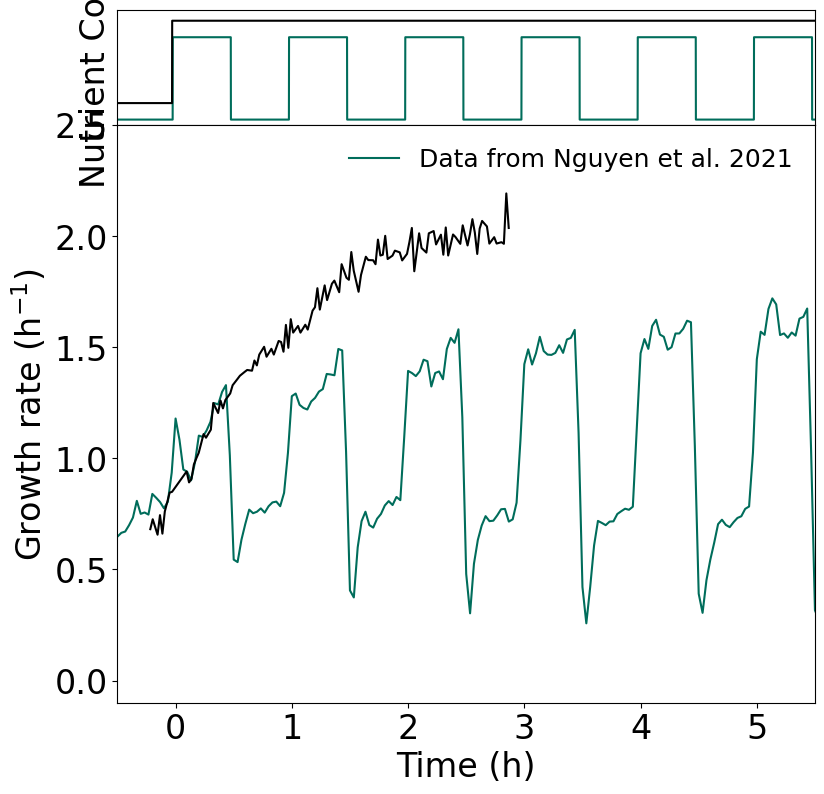

In [ ]:
kn0_high = 1500
kn0_low = 2.4

simulation_min = 3
simulation_max = 11 # in hrs
n_points = 20000 #number of simulation points
period = 1 # time period of nutrient flucuations, in hrs
t_shift = 9.9

t = np.linspace(simulation_min,simulation_max,n_points)

# Plot Layout
plt.rc('font', size=24) #controls default text size
plt.rc('legend', fontsize=18) #fontsize of the legend
fig = plt.figure(figsize=(9,9))
gs = gridspec.GridSpec(2,1, height_ratios=[1,5])

ax1 = plt.subplot(gs[0])
k_n0 = lambda t: (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + 2.1*np.pi/2)/2 + 0.5) + kn0_low + (kn0_high - kn0_low) * (signal.square(2*np.pi*t/period + 2.1*np.pi/2 + np.pi)/2 + 0.5) * np.heaviside(t - t_shift, 0.5)
ax1.plot(t - 3.5, k_n0(t), color='#006D5B')
k_n0 = lambda t: (kn0_high - kn0_low) * np.heaviside(t - simulation_min - 0.5, 0.5) + kn0_low
ax1.plot(t - 3.53, k_n0(t) + 300, color='k')
ax1.set_ylabel('Nutrient Conc.')
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xlim(-0.5,5.5)
ax1.set_ylim(-100,2000)

ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(Time - 3.5, GRates, color='#006D5B', label='Data from Nguyen et al. 2021')
ax2.plot(df['t']/60 - 0.03, df['k']*np.log(2), color='k')
plt.xlabel('Time (h)')
plt.ylabel('Growth rate (h$^{-1}$)')
ax2.set_xlim(-0.5,5.5)
ax2.set_ylim(-0.1,2.5)
plt.legend(frameon=False)
plt.subplots_adjust(hspace=.0)